### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS', remove unplanned
df = df[(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS') & (df['Unplanned?'] != 1)]
df = df.dropna()

### Create bins for the output for classification 

In [3]:
# Compute quantiles from 0.0 to 1.0 in 0.1 steps
quantiles = df['Duration_Hours'].quantile(np.arange(0, 1.1, 0.1))

# Drop duplicate bin edges to avoid pd.cut() error
bins = np.unique(quantiles.values)

# Create readable labels
labels = [f"{round(bins[i], 1)}–{round(bins[i+1], 1)} hrs" for i in range(len(bins) - 1)]

# Bin the data
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, include_lowest=True)

# Check the bin distribution
print(df['Duration_Category'].value_counts().sort_index())

Duration_Category
0.2–6.5 hrs         227
6.5–9.0 hrs         274
9.0–10.0 hrs        435
10.0–11.5 hrs       216
11.5–12.0 hrs       396
12.0–12.5 hrs        54
12.5–55.2 hrs       190
55.2–153.6 hrs      305
153.6–3950.4 hrs    140
Name: count, dtype: int64


### Random forest classification

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def train_and_evaluate_logistic(df, labels, train_model=True, model=None, test_size=0.2, random_state=42):
    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours',  # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',  # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description'  # categorical columns
                ]
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Standardize numeric features
    scaler = StandardScaler()
    X[['Recall_Day_Hours', 'Recall_Night_Hours']] = scaler.fit_transform(X[['Recall_Day_Hours', 'Recall_Night_Hours']])

    # --- 4. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 5. Train Model (if needed)
    if train_model or model is None:
        model = LogisticRegression(
            multi_class='multinomial',
            solver='lbfgs',
            max_iter=1000,
            class_weight='balanced',
            random_state=random_state
        )
        model.fit(X_train, y_train)

    # --- 6. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 7. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 8. Label Order
    full_label_order = labels
    present_labels = [label for label in full_label_order if label in y_test.unique()]

    # --- 9. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 10. Visualization
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # --- Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    ax1 = fig.add_subplot(gs[0, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[0, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    # --- Duration Category Distributions
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    train_counts = train_categories.reindex([label for label in full_label_order if label in train_categories.index])
    test_counts = test_categories.reindex([label for label in full_label_order if label in test_categories.index])

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return model


c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.36      0.09      0.15        44
     6.5–9.0 hrs       0.48      0.48      0.48        62
    9.0–10.0 hrs       0.32      0.44      0.37        80
   10.0–11.5 hrs       0.41      0.57      0.48        51
   11.5–12.0 hrs       0.62      0.27      0.37        75
   12.0–12.5 hrs       0.08      0.27      0.12        11
   12.5–55.2 hrs       0.21      0.23      0.22        39
  55.2–153.6 hrs       0.52      0.30      0.38        56
153.6–3950.4 hrs       0.32      0.50      0.39        30

        accuracy                           0.36       448
       macro avg       0.37      0.35      0.33       448
    weighted avg       0.42      0.36      0.36       448



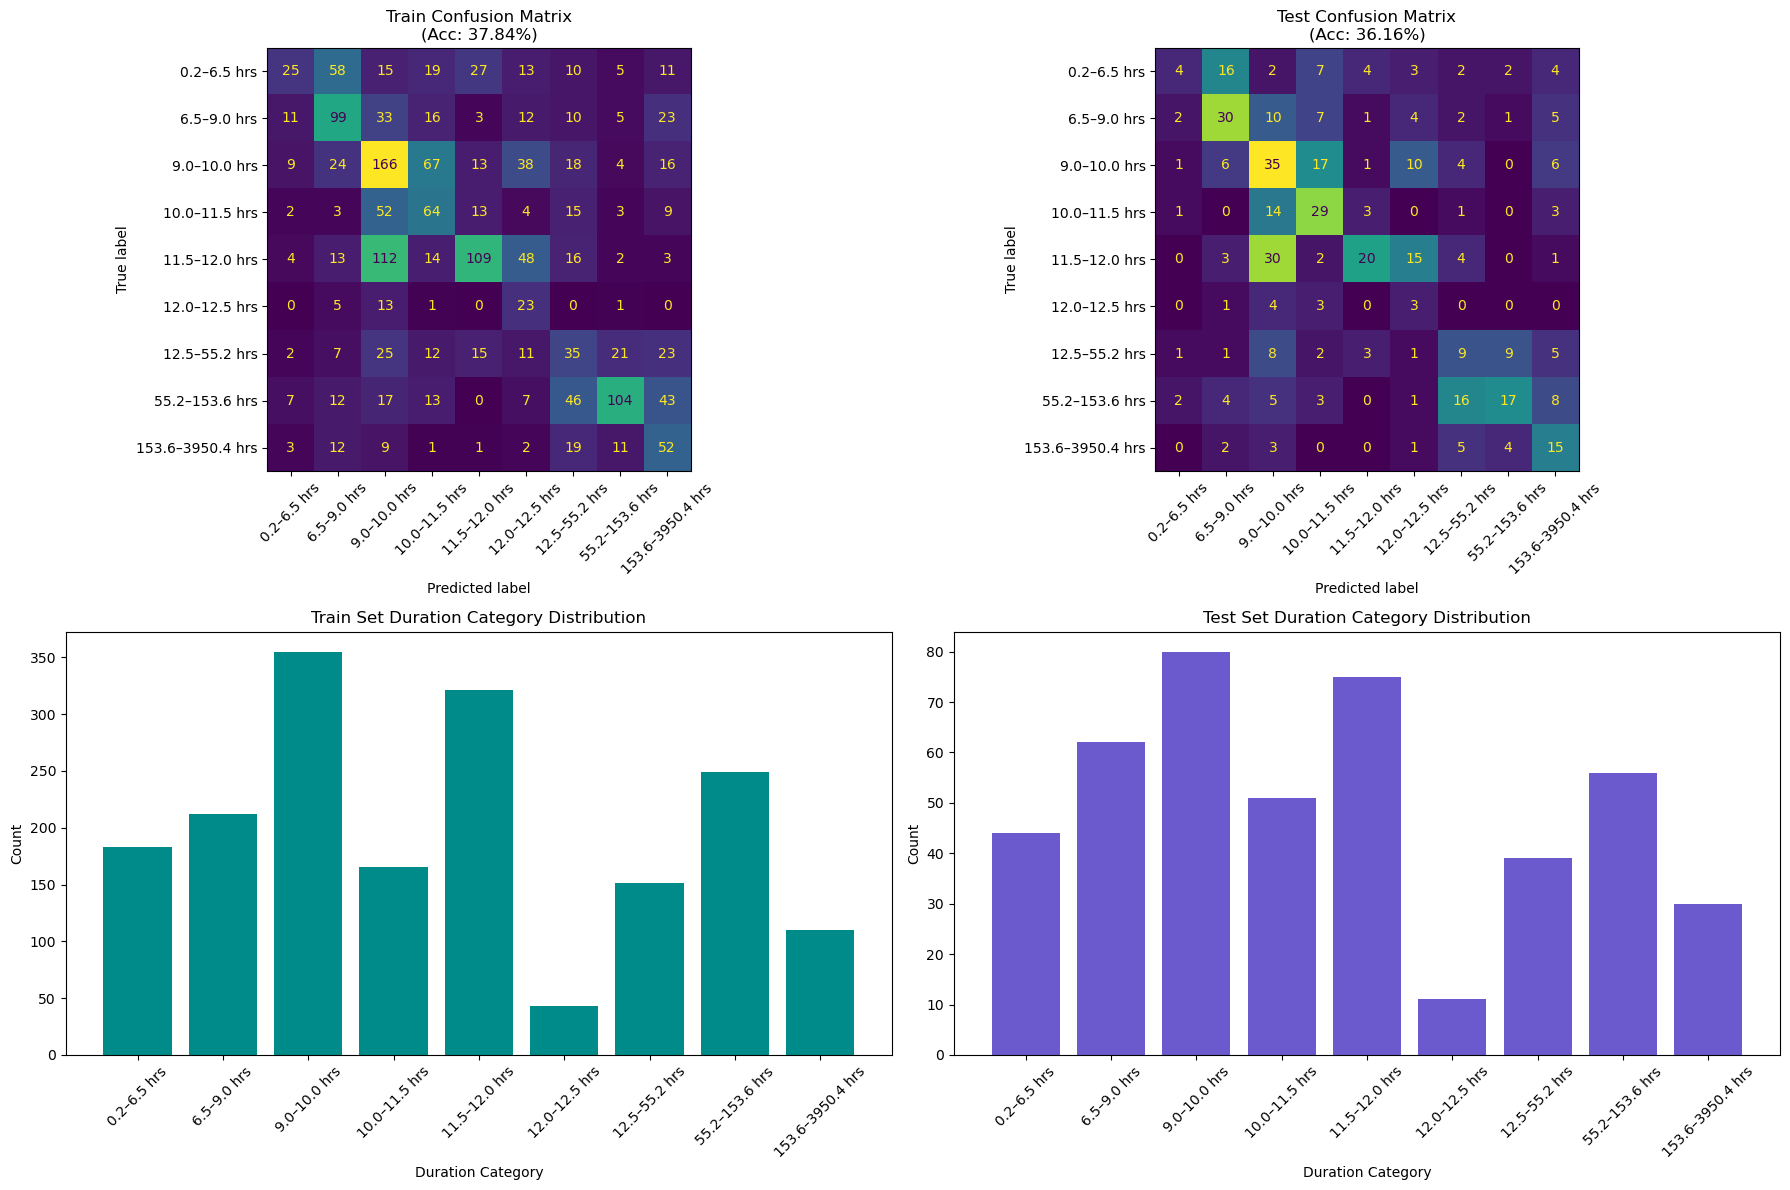

In [5]:
# from data.functions.random_forest_model_and_eval import train_and_evaluate_rf
model = train_and_evaluate_logistic(df, labels)

--- Region: SA ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.33      0.11      0.17         9
     6.5–9.0 hrs       0.00      0.00      0.00         2
   10.0–11.5 hrs       0.00      0.00      0.00         1
   11.5–12.0 hrs       0.25      0.50      0.33         4
   12.5–55.2 hrs       0.60      0.30      0.40        10
  55.2–153.6 hrs       0.50      0.24      0.32        21
153.6–3950.4 hrs       0.54      0.78      0.64         9

       micro avg       0.38      0.32      0.35        56
       macro avg       0.32      0.28      0.27        56
    weighted avg       0.45      0.32      0.35        56



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_clas

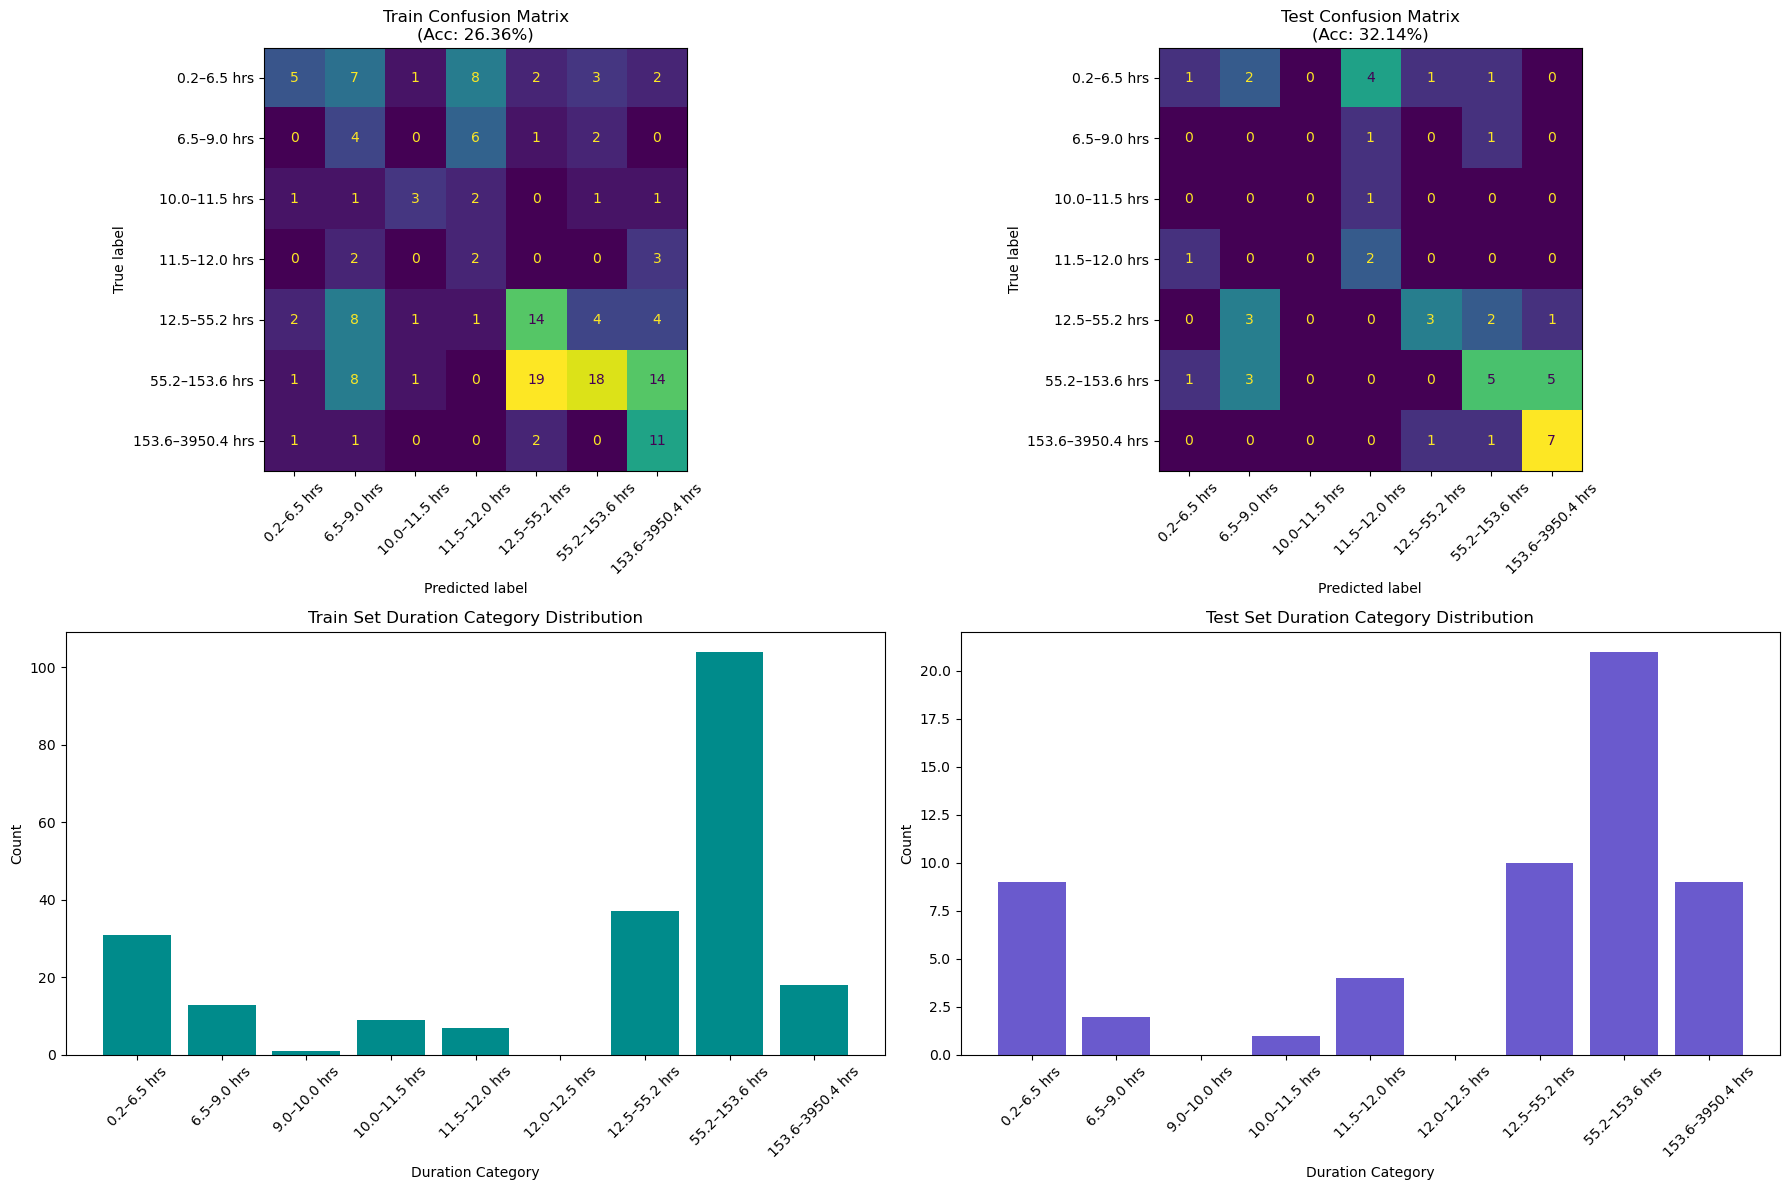

--- Region: VIC ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.27      0.32      0.29        19
     6.5–9.0 hrs       0.50      0.05      0.10        19
    9.0–10.0 hrs       0.40      0.37      0.38        63
   10.0–11.5 hrs       0.31      0.31      0.31        29
   11.5–12.0 hrs       0.75      0.29      0.42        73
   12.0–12.5 hrs       0.12      0.50      0.20         6
   12.5–55.2 hrs       0.67      0.29      0.40        14
  55.2–153.6 hrs       0.18      0.29      0.22        14
153.6–3950.4 hrs       0.04      0.40      0.07         5

        accuracy                           0.30       242
       macro avg       0.36      0.31      0.27       242
    weighted avg       0.48      0.30      0.34       242



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


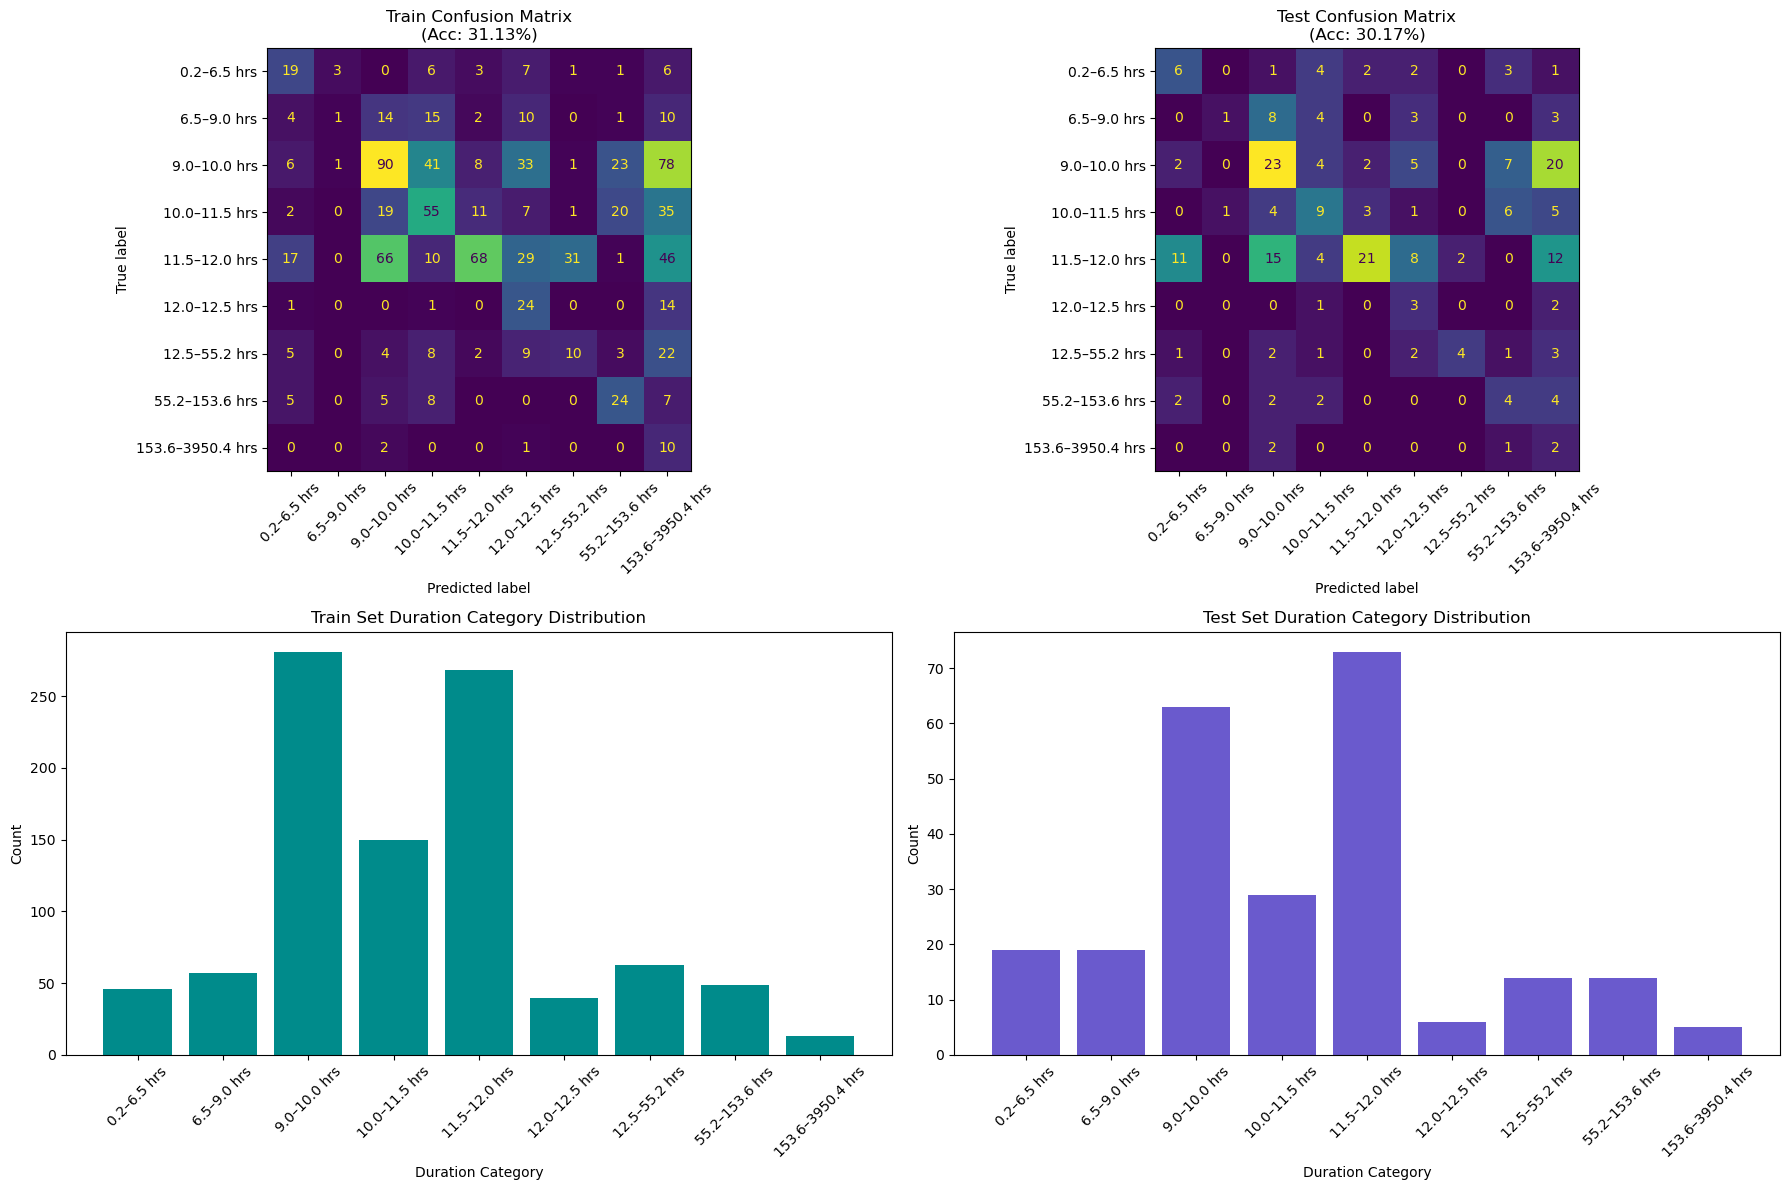

--- Region: TAS ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.71      0.56      0.62         9
     6.5–9.0 hrs       0.50      0.71      0.59         7
    9.0–10.0 hrs       0.00      0.00      0.00         1
   10.0–11.5 hrs       0.00      0.00      0.00         1
   12.5–55.2 hrs       0.50      1.00      0.67         1
  55.2–153.6 hrs       1.00      0.17      0.29         6
153.6–3950.4 hrs       0.00      0.00      0.00         2

        accuracy                           0.44        27
       macro avg       0.39      0.35      0.31        27
    weighted avg       0.61      0.44      0.45        27



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_clas

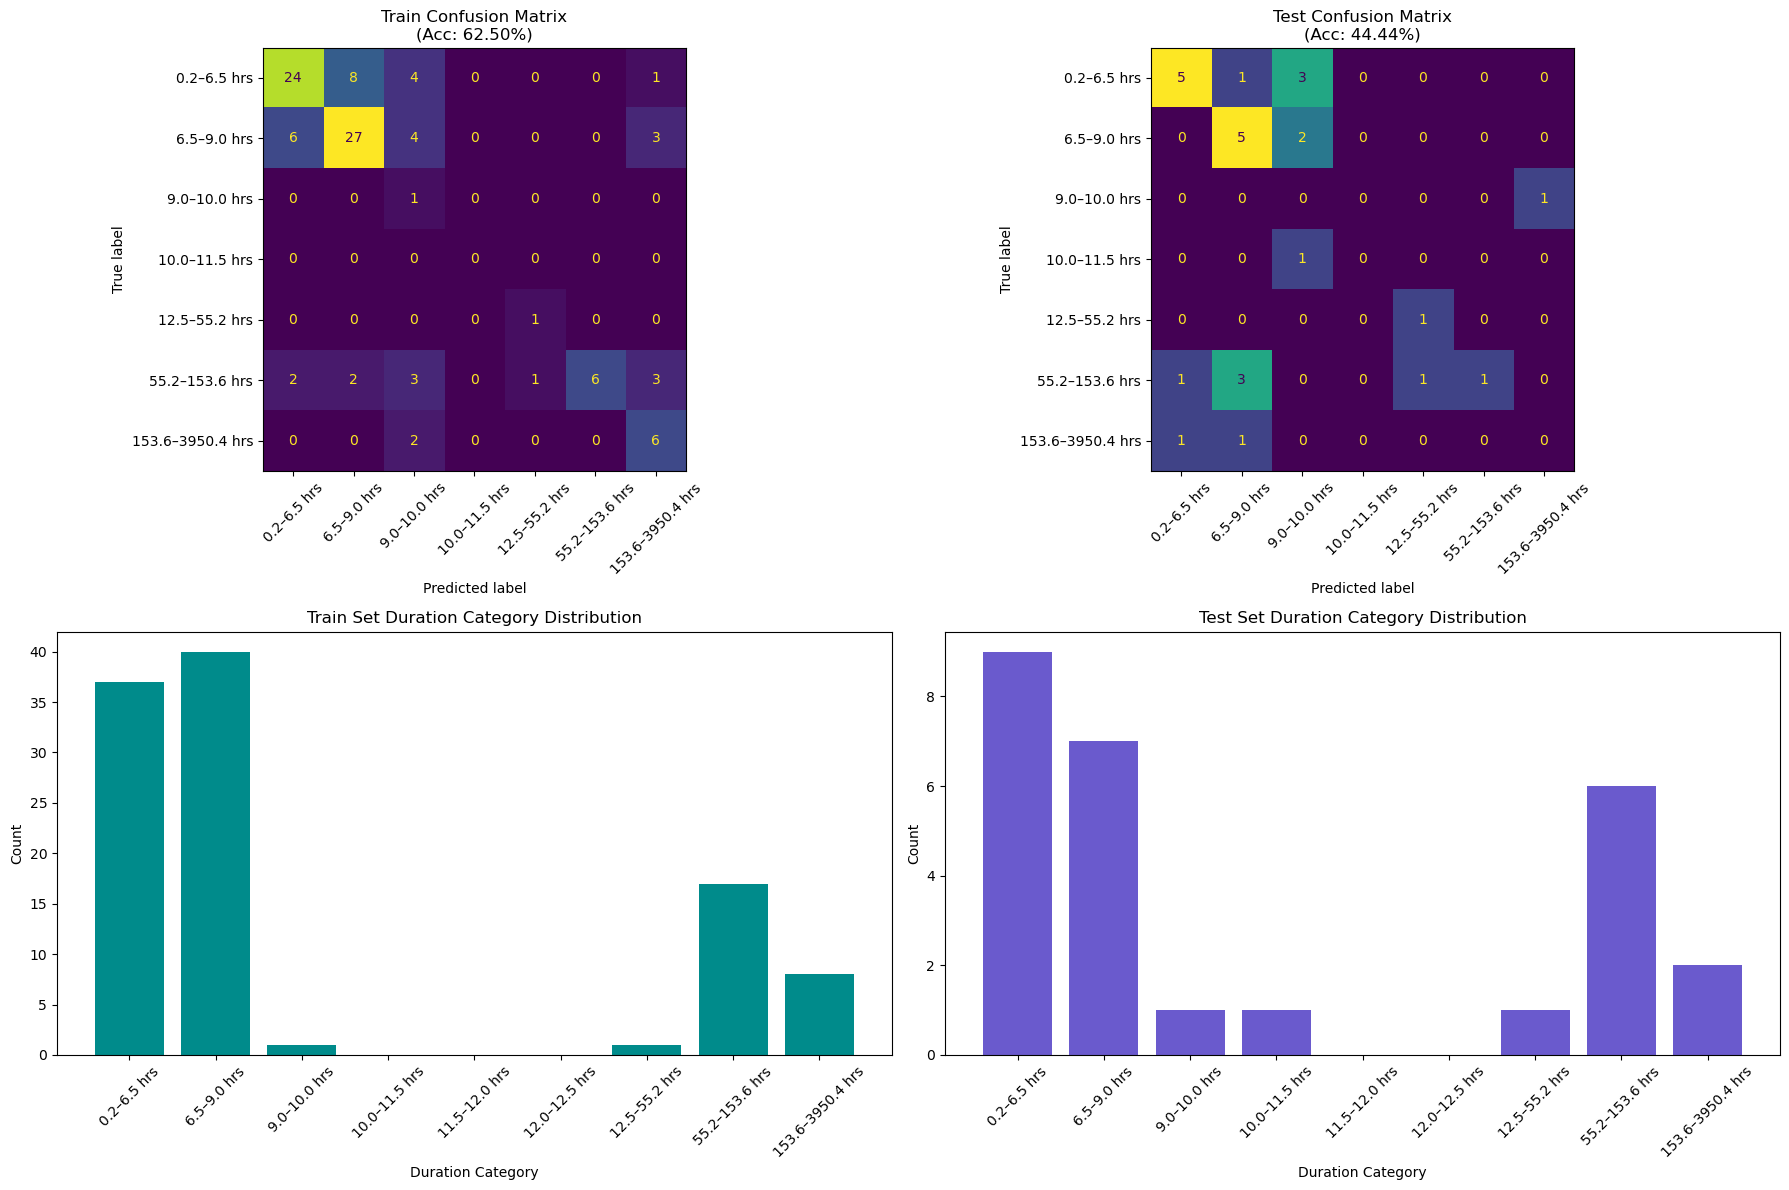

--- Region: QLD ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.20      0.25      0.22        12
     6.5–9.0 hrs       0.70      0.26      0.38        27
    9.0–10.0 hrs       0.00      0.00      0.00         5
   12.0–12.5 hrs       0.00      0.00      0.00         1
   12.5–55.2 hrs       0.23      0.50      0.32         6
  55.2–153.6 hrs       0.38      0.43      0.40         7
153.6–3950.4 hrs       0.67      0.46      0.55        13

       micro avg       0.33      0.31      0.32        71
       macro avg       0.31      0.27      0.27        71
    weighted avg       0.48      0.31      0.35        71



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


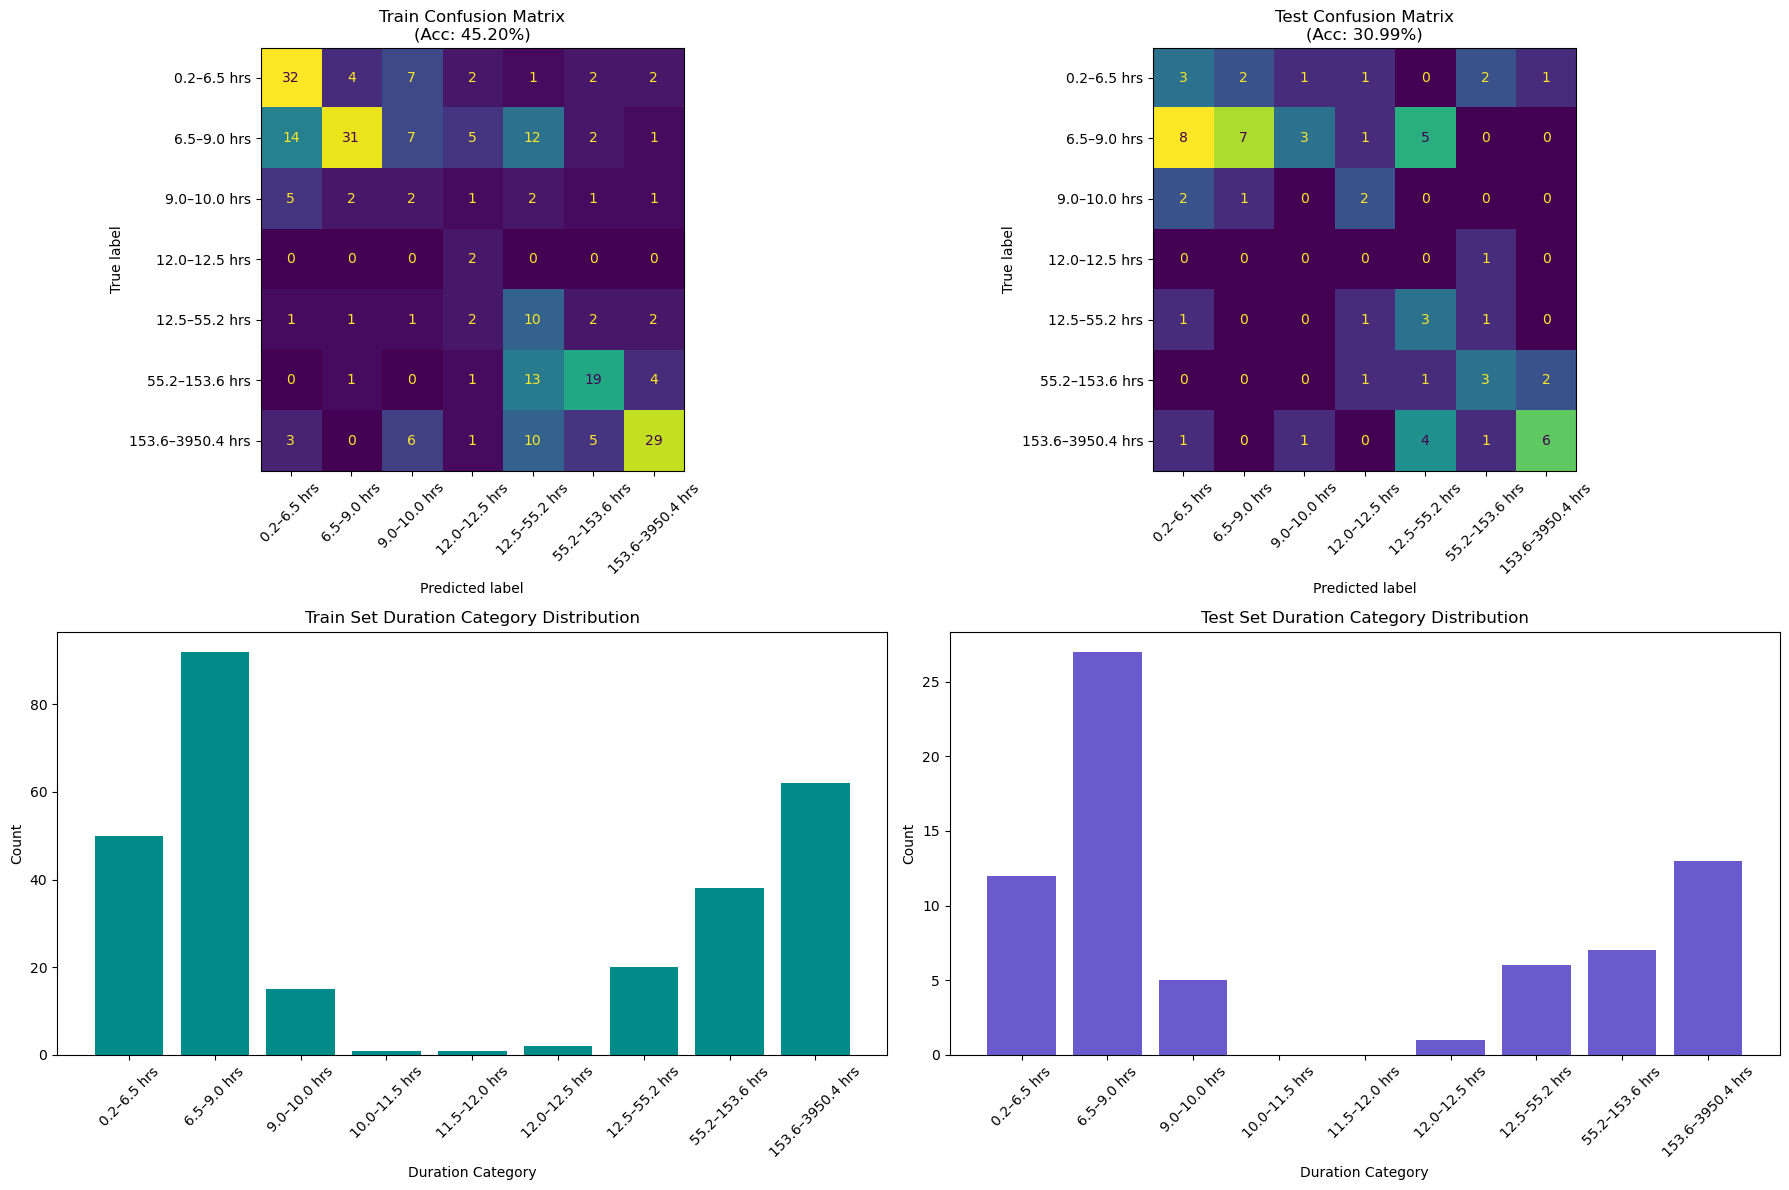

--- Region: NSW ---
Classification Report (Test Set):
                  precision    recall  f1-score   support

     0.2–6.5 hrs       0.33      0.40      0.36         5
     6.5–9.0 hrs       0.00      0.00      0.00         3
    9.0–10.0 hrs       0.45      0.33      0.38        15
   10.0–11.5 hrs       0.18      0.33      0.24         6
   11.5–12.0 hrs       0.12      0.17      0.14         6
   12.5–55.2 hrs       0.50      0.22      0.31         9
  55.2–153.6 hrs       0.67      0.44      0.53         9
153.6–3950.4 hrs       0.00      0.00      0.00         1

       micro avg       0.34      0.30      0.32        54
       macro avg       0.28      0.24      0.25        54
    weighted avg       0.39      0.30      0.32        54



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_clas

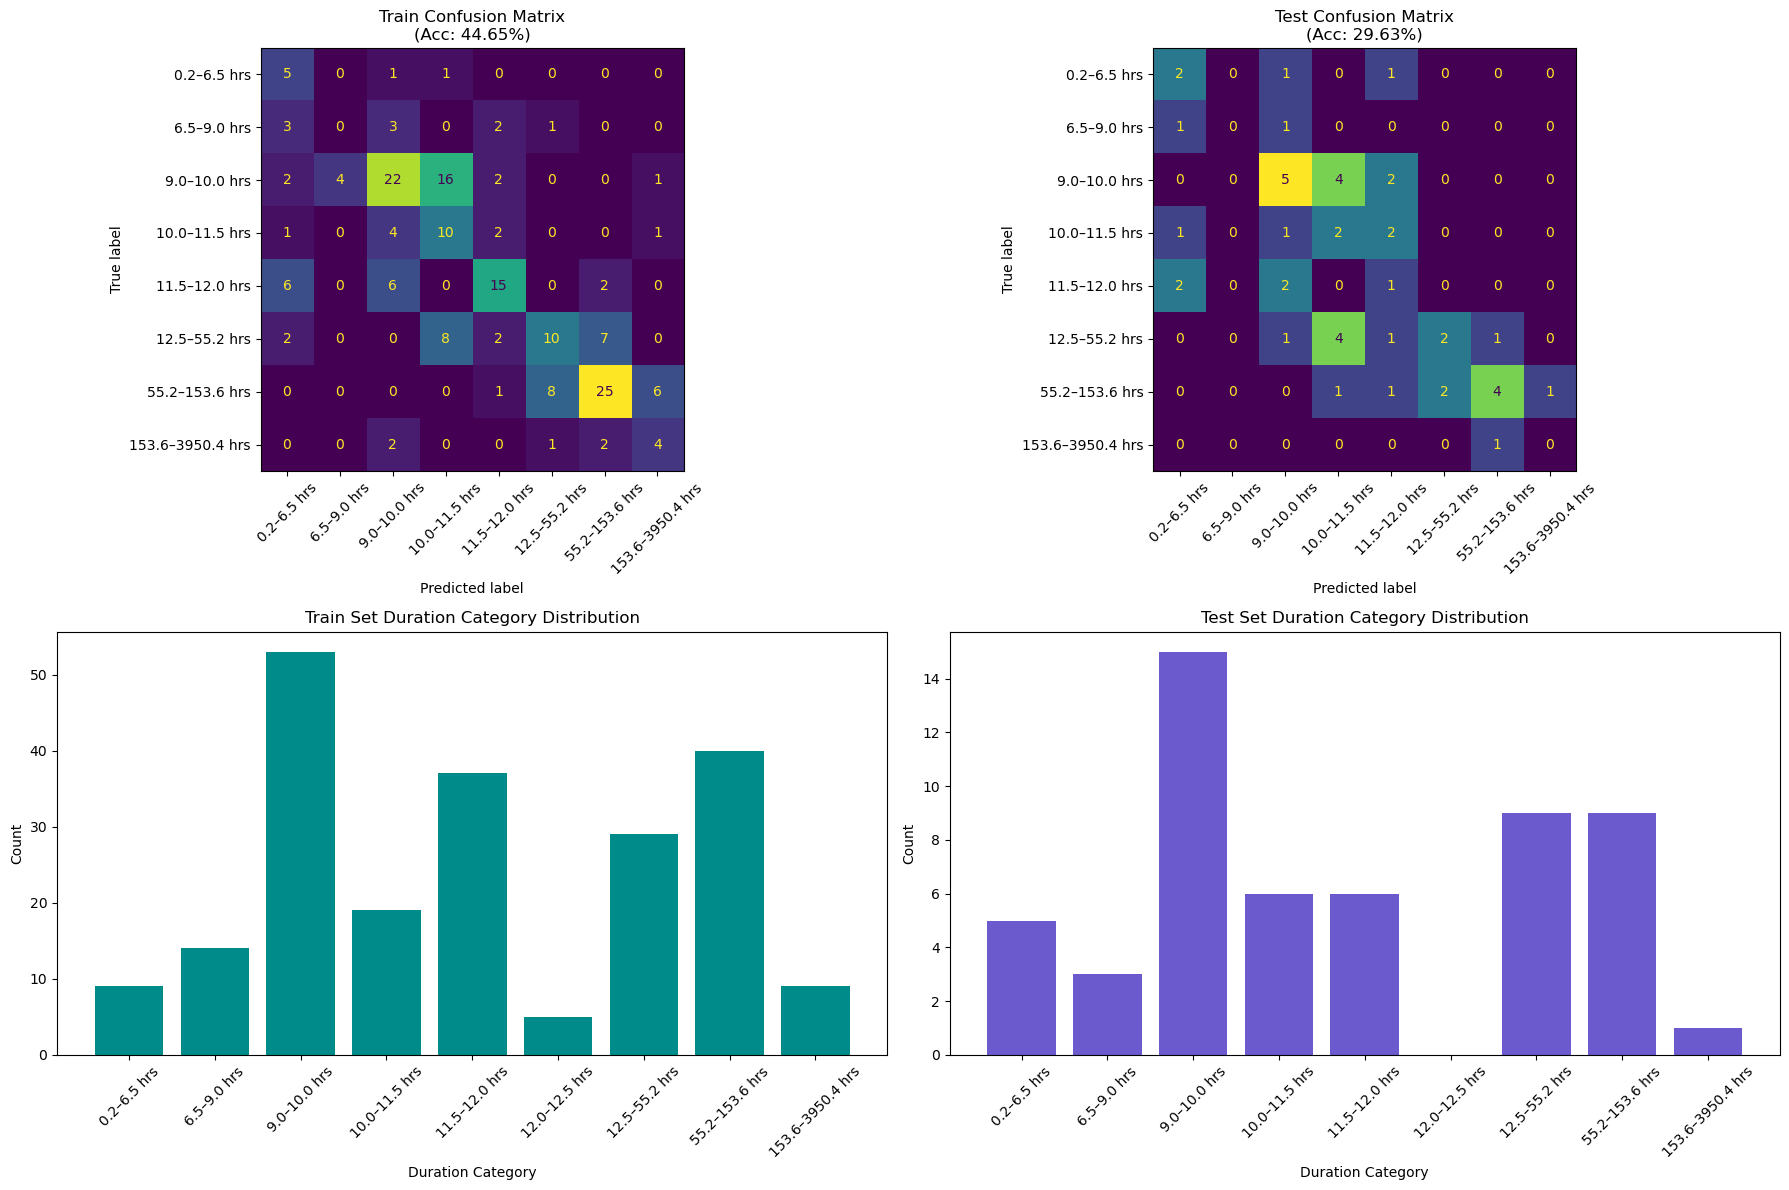

In [6]:
region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_logistic(region_df, labels)
    region_models[region] = model